# Stability Analysis of USDN coin

In [1]:
import os, sys
import requests
import pandas as pd
import numpy as np
from datetime import timedelta as td, datetime as dt, timezone
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

# Scripts
scripts_module_path = os.path.abspath(os.path.join(os.getcwd(),'..', 'scripts'))
if scripts_module_path not in sys.path:
    sys.path.append(scripts_module_path)
from acquisition import Acquisition as Akw
from handling import getDataFrame, addReversionAndVolatility, addAverages
from viz import createBasicAnalysisPlot

In [2]:
# common keywords
basic_kwargs = dict(granularity='days')

# required for data acquisition
acquisition_kwargs = dict(**basic_kwargs,
                          datetime_from=dt.now() - td(days=523),
                          datetime_till=dt.now(),
                          downloadIfMissing=True,
                          includeOffPeg=True)
# required for the estimation of the reversion rate
reversion_kwargs = dict(**basic_kwargs,
                        windowSize=85,
                        minDataPoints=60,
                        discount_factor = 0.1,
                        sampleError=0.0001,
                        verbose=True)

## Reversion rate, Volatility and depegging of Neutrino USD

In [5]:
usdn = getDataFrame(whichData="cg_usdn_usd", **acquisition_kwargs)
usdn_df = addReversionAndVolatility(usdn, **reversion_kwargs)
addAverages(usdn_df, columns=["price", "rate", "sigma"], com=5, inplace=True)

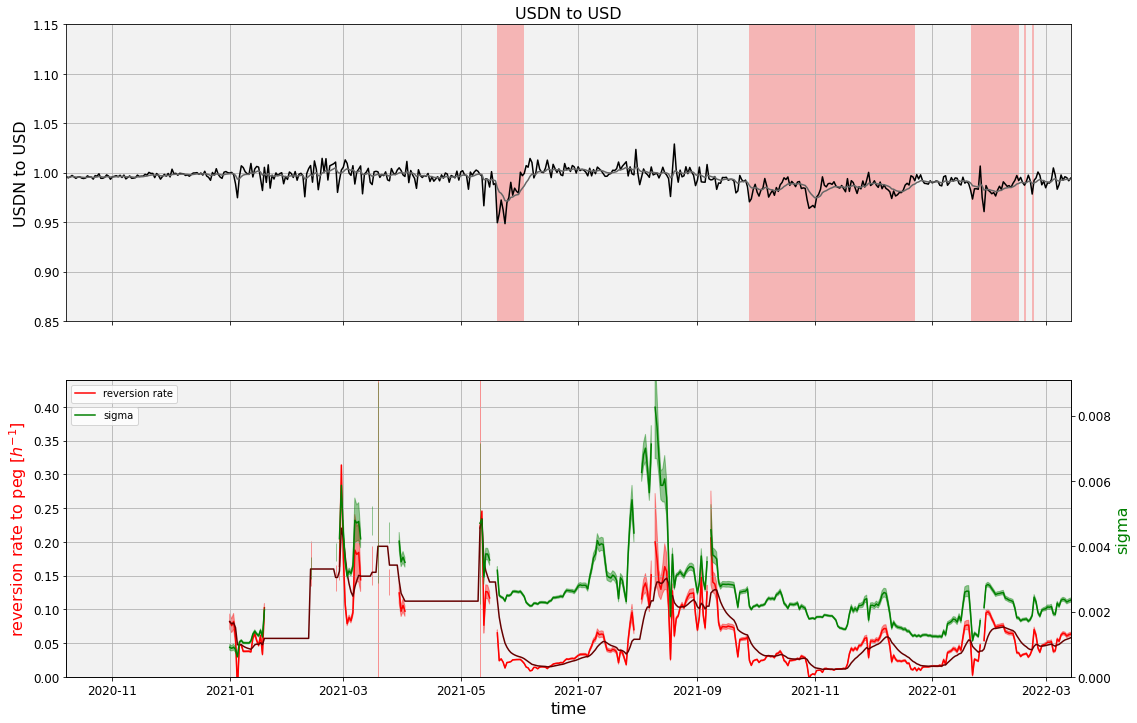

In [7]:
fig, axes, secax = createBasicAnalysisPlot(df=usdn_df, title="USDN to USD", price_dev=0.08)
axes[0].plot(usdn_df.date, usdn_df.price_ewm, color="#666")
axes[1].set_ylim([0,usdn_df.rate.max()*(1+0.4)])
secax[1].set_ylim([0,usdn_df.sigma.max()*(1+0.1)])
axes[1].plot(usdn_df.date, usdn_df.rate_ewm, color="#600")
axes[0].set_ylim([0.85,1.15])
axes[0].fill_between(usdn_df["date"], 0.8, 1.15, 
                where=(usdn_df.price_ewm>1.01) | (usdn_df.price_ewm<0.99),
                facecolor='red',
                alpha=0.25)
plt.show()

The first figure shows the price of `Neutrino USD (USDN)` against `USD` as recorded by coingecko. The grey line shows an exponentially weighted moving average. There has been one depegging event in the end of May 2021 and since the fall of 2021 `USDN` seems to trade a bit below the dollar on average, indicated by the red intervals. It only now starts to recover again into more healthy territory.

This reluctance to revert can also be seen in a very low reversion rate  (`red`), where for the large part of fall 2021 the rate has dropped below 0.05 and only very recently managed to crawl up again. Volatility  (`green`) on the other hand is less of an issue for `USDN`, compared to its depegging and and slow reversion. 